In [1]:
from gpt3forchem.api_wrappers import _get_embedding
from gpt3forchem.baselines import compute_morgan_fingerprints
import matplotlib.pyplot as plt 
import pandas as pd 
import umap

plt.style.use(['science', 'nature'])

/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/gpflow/experimental/utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.decorator.check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(
/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/gpflow/experimental/utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.inheritance.inherit_check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(
/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
modelname = 'ada:ft-lsmoepfl-2022-09-01-12-21-05'

In [3]:
train_file = 'run_files/2022-09-01-14-17-18_train_prompts_photoswitch_regression_313.jsonl'
train_prompts = pd.read_json(train_file, lines=True, orient='records')
test_file = 'run_files/2022-09-01-14-17-18_valid_prompts_photoswitch_regression_79.jsonl'
test_prompts = pd.read_json(test_file, lines=True, orient='records')

In [4]:
predictions = pd.read_csv('results/2022-09-01-14-17-18_photoswitch_regression_predictions.csv')

In [5]:
morgan_fps = compute_morgan_fingerprints(predictions['SMILES'].values)

In [14]:
mapper = umap.UMAP()

In [15]:
red = mapper.fit_transform(morgan_fps)

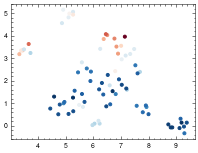

In [16]:
plt.scatter(red[:,0], red[:,1], c=predictions['true'].values, cmap='RdBu_r')

Ok, the Morgan fingerprint does some clustering that can explain the wavelengths.

(Actually, not sure what hyperparameters they used in the paper, the plots there looked nicer)

In [22]:
import openai

In [25]:
test_prompts['prompt'].iloc[0]

'what is the transition wavelength of CC1=NOC(C)=C1/N=N/C2=C(Cl)C=CC=C2###'

In [20]:
embeddings = _get_embedding(list(test_prompts['prompt'].values[0:20]), modelname) # using only 20 as I suspect that also this endpoint has a limit

PermissionError: You are not allowed to generate embeddings from this model

Ok, I guess they cannot give us embeddings for fine-tuned classification models.

In [27]:
from scipy.spatial.distance import cdist

In [28]:
pairwise_fingerprint_distances = cdist(morgan_fps, morgan_fps, metric='jaccard')

In [29]:
pairwise_fingerprint_distances

array([[0.        , 0.85542169, 0.87777778, ..., 0.89393939, 0.85294118,
        0.89285714],
       [0.85542169, 0.        , 0.76086957, ..., 0.85333333, 0.8625    ,
        0.92857143],
       [0.87777778, 0.76086957, 0.        , ..., 0.87804878, 0.87209302,
        0.93421053],
       ...,
       [0.89393939, 0.85333333, 0.87804878, ..., 0.        , 0.69811321,
        0.89583333],
       [0.85294118, 0.8625    , 0.87209302, ..., 0.69811321, 0.        ,
        0.88461538],
       [0.89285714, 0.92857143, 0.93421053, ..., 0.89583333, 0.88461538,
        0.        ]])

In [30]:
pairwise_prediction_distances = cdist(predictions['prediction'].values.reshape(-1,1), predictions['prediction'].values.reshape(-1,1), metric='euclidean')

In [32]:
pairwise_true_distance = cdist(predictions['true'].values.reshape(-1,1), predictions['true'].values.reshape(-1,1), metric='euclidean')

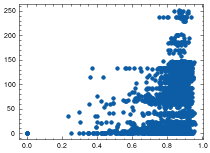

In [31]:
plt.scatter(pairwise_fingerprint_distances.flatten(), pairwise_prediction_distances.flatten())

In [34]:
import numpy as np

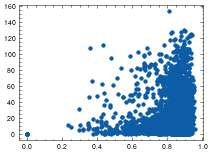

In [41]:
plt.scatter(pairwise_fingerprint_distances.flatten(), np.abs(pairwise_true_distance.flatten() -pairwise_prediction_distances.flatten()))